# Import packages and data

In [1]:
import sys
sys.path.append('/well/mars/users/uvy786/python')

# if extra packages needed, try !conda install -c channel_name package_name, 
# then !{sys.executable} -m pip install <package_name>

In [2]:
import pandas as pd
import numpy as np
import random
import os
from datatable import fread

import torch
import torch.nn.functional as F
from torch                    import nn
from torch.optim              import SGD
from torch.optim.lr_scheduler import OneCycleLR

from skorch                   import NeuralNetClassifier
from skorch.callbacks         import LRScheduler
from skorch.helper            import DataFrameTransformer


In [3]:
import matplotlib.pyplot as plt
from pyminc.volumes.factory import volumeFromFile

In [44]:
atlas = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_labels_200um.mnc'
anat = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_average_200um.mnc'
mask = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_mask_200um.mnc'

input_data_voxel = '/well/mars/users/uvy786/dl_mouse_human/data/mouse_human/data.ign/MouseExpressionMatrix_voxel_coronal_maskcoronal_log2_grouped_imputed_labelled_scaled.csv'
output_data_voxel = '/well/mars/users/uvy786/dl_mouse_human/exps/e1_ae/results.ign/3layers/50_DO_weight_decay_e-1/test/autoencoding/mouse_voxel_autoencoding.csv'

input_data = (fread(input_data_voxel, header=True).to_pandas())
output_data = (fread(output_data_voxel, header=True).to_pandas())



Exception ignored in: /minc-toolkit-v2/libminc/libsrc2/volume.c:1613 (from miopen): <function mincVolume.__del__ at 0x7f20bbd11e50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pyminc/volumes/volumes.py", line 798, in __del__
Error: Trying to close null volume
    self.closeVolume()
  File "/usr/local/lib/python3.8/dist-packages/pyminc/volumes/volumes.py", line 785, in closeVolume
    testMincReturn(r)
  File "/usr/local/lib/python3.8/dist-packages/pyminc/volumes/volumes.py", line 37, in testMincReturn
    raise mincException
pyminc.volumes.volumes.mincException: 


# Prepare data
The input data is a matrix of gene expression value throughout the brain. It also contains columns that label the voxels belonging to the same atlas areas, with different options for granularity. We are going to look at granularity corresponding to 67 regions. We need to separate the data from the labels for downstream analysis. For deep learning analysis we would also want to convert the dataframes to tensors or np arrays.

The output data from the autoencoder is the same as the input data, except for the label columns of which it has only one, named Region.

In [45]:
# Identify columns with label data
indLabels = input_data.columns.str.match('Region')
# Extract all other columns, ie the data columns
dfInput = input_data.loc[:,~indLabels]
# Extract the label column for the desired granularity
labelcol = 'Region67'
dfLabels = input_data[[labelcol]].copy()

# Change labels into categorical variable
dfLabels.loc[:,labelcol] = dfLabels.loc[:,labelcol].astype('category')

# Create instance of the dataframe transformer
dtfx = DataFrameTransformer()

# Fit and transform the input and label dataframes
X_temp = dtfx.fit_transform(dfInput)
y_temp = dtfx.fit_transform(dfLabels)

# Extract arrays from the dictionnaries
X = X_temp['X']
y = y_temp[labelcol]


# Do the same for output data

indLabelsAE = output_data.columns.str.match('Region')
dfOutput = output_data.loc[:,~indLabelsAE]
labelcolAE = 'Region'
dfLabelsAE = output_data[[labelcolAE]].copy()
# Change labels into categorical variable
dfLabelsAE.loc[:,labelcolAE] = dfLabelsAE.loc[:,labelcolAE].astype('category')


# Fit and transform the input and label dataframes
X_tempAE = dtfx.fit_transform(dfOutput)
y_tempAE = dtfx.fit_transform(dfLabelsAE)

# Extract arrays from the dictionnaries
X_AE = X_tempAE['X']
y_AE = y_tempAE[labelcolAE]


In [46]:
# Compute input output difference 
X_diff = X - X_AE

X_diff_mean = np.mean(X_diff, axis=0)


#Get gene names
genes = dfInput.columns.to_numpy()
#Sorted values
mean_sorted, genes_sorted = zip(*sorted(zip(X_diff_mean, genes)))

#Array of x values for plotting
x_pos = np.arange(len(genes))

genes

array(['A4GALT', 'AACS', 'AARS', ..., 'ZSCAN22', 'ZSWIM6', 'ZYX'],
      dtype=object)

Text(0.5, 1.0, 'Ordered mean input output expression differences')

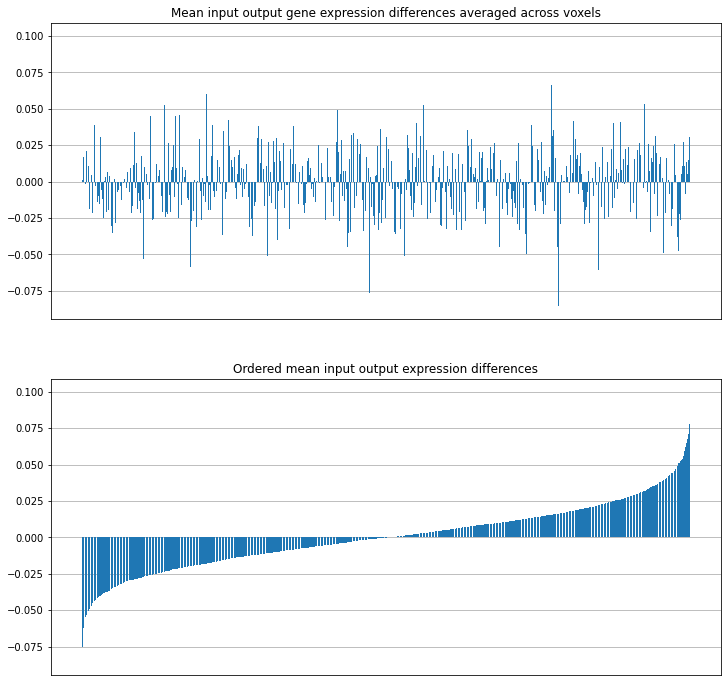

In [47]:
# Plot the distribution of the difference across genes

# TODO! Plot the distribution of misclassified voxels, maybe averaged across regions

fig, axes = plt.subplots(2, 1, figsize = (12, 12))

axes[0].grid(zorder = 0, axis = 'y')
axes[0].bar(x_pos, X_diff_mean, zorder = 2)
axes[0].set_xticks([])
axes[0].set_title('Mean input output gene expression differences averaged across voxels')

axes[1].grid(zorder=0, axis='y')
axes[1].bar(x_pos, mean_sorted, zorder=2)
axes[1].set_xticks([])
axes[1].set_title('Ordered mean input output expression differences')



# Zoom in to look at differences >0.05

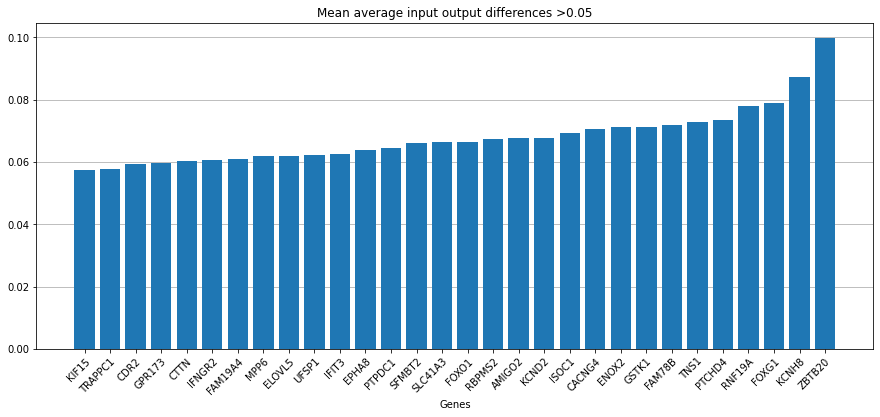

In [48]:
fig, ax = plt.subplots(figsize = (15,6))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[-30:], mean_sorted[-30:], align = 'center', zorder = 2)
ax.set_xticks(x_pos[-30:], genes_sorted[-30:], rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Genes')
ax.set_title('Mean average input output differences >0.05')
plt.show()

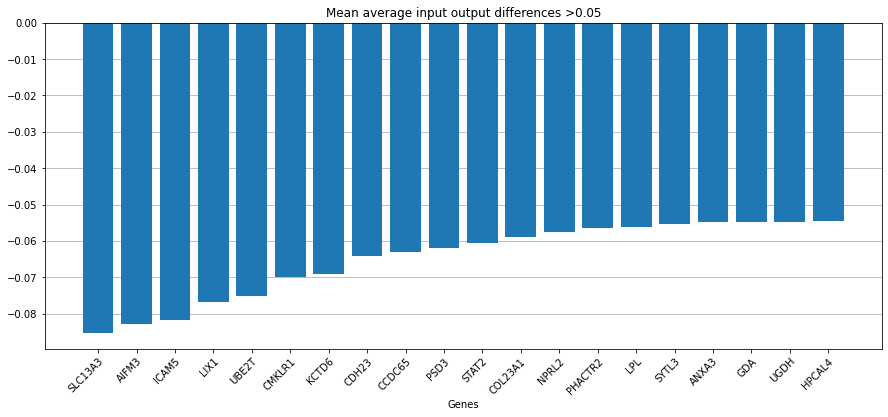

In [49]:
fig, ax = plt.subplots(figsize = (15,6))
ax.grid(zorder = 0, axis = 'y')
ax.bar(x_pos[0:20], mean_sorted[0:20], align = 'center', zorder = 2)
ax.set_xticks(x_pos[0:20], genes_sorted[0:20], rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Genes')
ax.set_title('Mean average input output differences >0.05')
plt.show()

# Visualize gene expression maps of genes ZBTB20 and KCNH8

In [50]:
expr_zbt20_a = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/expression/coronal/Zbtb20_1143.mnc'
expr_zbt20_b = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/expression/coronal/Zbtb20_79568020.mnc'

In [51]:
kcnh8_file = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/expression/coronal/Kcnh8_70562113.mnc'

In [52]:
zbt20a = volumeFromFile(expr_zbt20_a)
zbt20a_data = np.array(zbt20a.data)
kcnh8 = volumeFromFile(kcnh8_file)
kcnh8_data = np.array(kcnh8.data)

In [53]:
atlas = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_labels_200um.mnc'
anat = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_average_200um.mnc'
mask = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/DSURQE_CCFv3_mask_200um.mnc'

mask2 = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/coronal_200um_coverage_bin0.8.mnc'

#file_test = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/data/MouseExpressionMatrix_voxel_coronal_maskcoronal_log2_grouped_imputed_labelled_scaled.csv'
#file_test = (fread(file_test).to_pandas())
# This file is corrupt, not enough genes. But still 51219 voxels.


mask = volumeFromFile(mask)
mask = np.array(mask.data)
mask2 = volumeFromFile(mask2)
mask2 = np.array(mask2.data)
anat = np.array(volumeFromFile(anat).data)
atlas = np.array(volumeFromFile(atlas, labels=True).data)

atlas_nan = np.zeros(atlas.shape)
atlas_nan[:,:,:]==atlas[:,:,:]
atlas_nan[mask2==0]=np.nan
anat[mask2==0]=np.nan

zbt20a_data[mask2 == 0] = np.nan
kcnh8_data[mask2 == 0] = np.nan

np.count_nonzero(~np.isnan(anat))
np.count_nonzero(atlas)


62099

Text(0.5, 1.0, 'ZBT20')

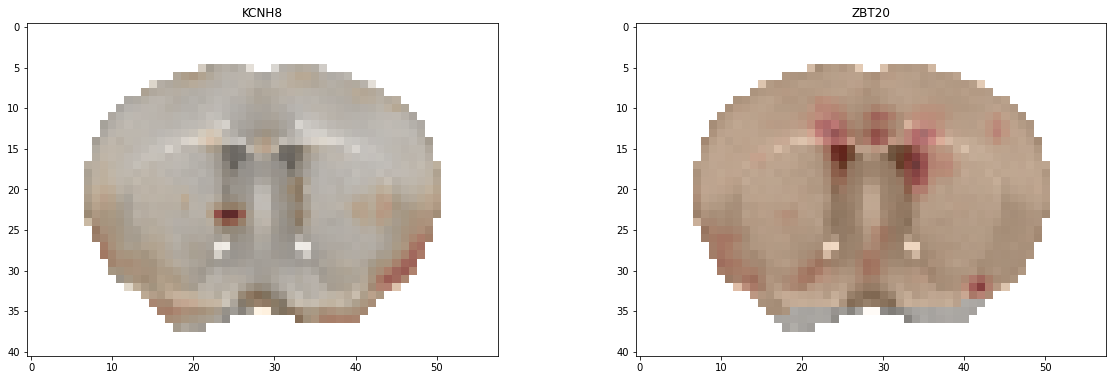

In [43]:
slc = 42
asp = anat.shape[1]/anat.shape[0]


anat_slice = np.flip(anat[:,slc,:], axis = 0)
atlas_slice = np.flip(anat[:,slc,:], axis = 0)
kcn_slice = np.flip(kcnh8_data[:,slc,:], axis = 0)
zbta_slice = np.flip(zbt20a_data[:,slc,:], axis = 0)

fig, axes = plt.subplots(1, 2, figsize = (2*10, 10/asp))

axes[0].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[0].imshow(kcn_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[0].set_title('KCNH8')

axes[1].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[1].imshow(zbta_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[1].set_title('ZBT20')



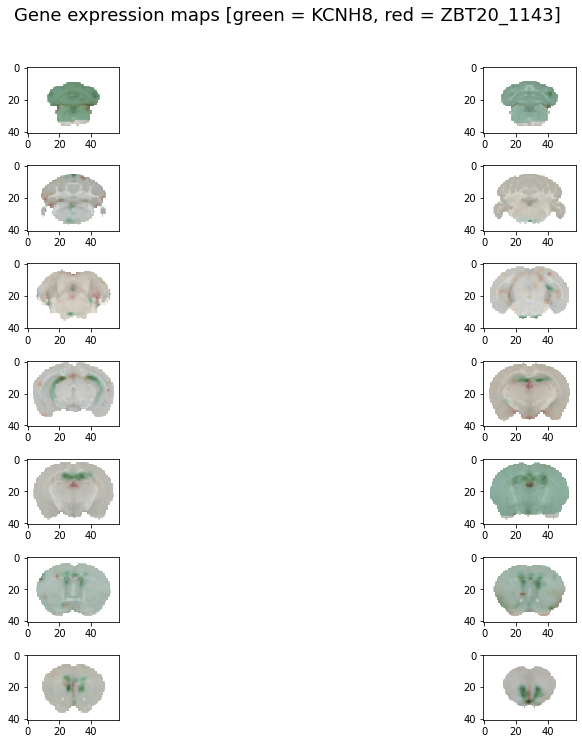

In [15]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Gene expression maps [green = KCNH8, red = ZBT20_1143]", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, slc in enumerate([2, 3, 7, 10, 15, 20, 25, 30, 32, 35, 40, 42, 46, 50]):
    # add a new subplot iteratively
    #asp = anat.shape[1]/anat.shape[0]
    
    anat_slice = anat[:,slc,:]
    expr1_slice = kcnh8_data[:,slc,:]
    expr2_slice = zbt20a_data[:,slc,:]

    anat_slice = np.flip(anat_slice, axis = 0)
    expr1_slice = np.flip(expr1_slice, axis = 0)
    expr2_slice = np.flip(expr2_slice, axis = 0)
    
    
    ax = plt.subplot(7, 2, n + 1)
    
    ax.imshow(anat_slice, cmap = plt.get_cmap('binary'))
    ax.imshow(expr1_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
    ax.imshow(expr2_slice, cmap = plt.get_cmap('BuGn'), alpha = 0.4)
    #ax.set_title(exprfile1)

# Look at the output of the autoencoder for these two genes

In [16]:
index_z = dfInput.columns.str.match('ZBTB20')
index_k = dfInput.columns.str.match('KCNH8')

np.shape(index_z)
np.shape(kcnh8_data)

(41, 67, 58)

In [17]:
ZBTB20_out = np.array(dfOutput.loc[:,index_z])
ZBTB20_in = np.array(dfInput.loc[:,index_z])

In [18]:
KCNH8_out = np.array(dfOutput.loc[:,index_k])

In [19]:
KCNH8_out_resized = KCNH8_out.copy()
ZBTB20_out_resized = ZBTB20_out.copy()
ZBTB20_in_resized = ZBTB20_in.copy()


np.shape(ZBTB20_out_resized)
np.cbrt((41*67*58)/51219)
28*46*40

51520

In [20]:
ZBTB20_out_resized = np.resize(ZBTB20_out_resized,(41,67,58))
KCNH8_out_resized = np.resize(KCNH8_out_resized,(41,67,58))
np.shape(ZBTB20_out_resized)

(41, 67, 58)

In [21]:
41/1.45
#67/1.45
#58/1.45

28.27586206896552

In [22]:
np.shape(ZBTB20_out_resized)

(41, 67, 58)

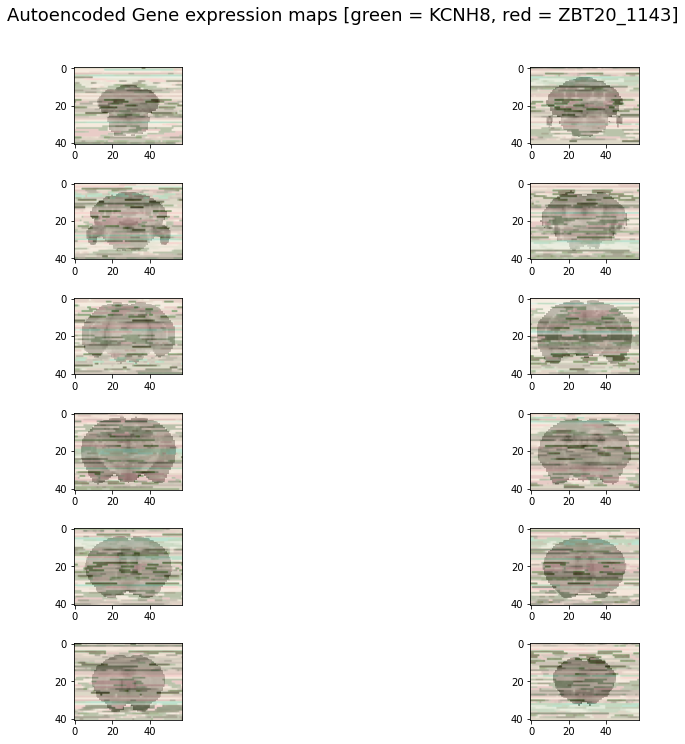

In [23]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Autoencoded Gene expression maps [green = KCNH8, red = ZBT20_1143]", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, slc in enumerate([2, 7, 10, 15, 20, 25, 30, 35, 40, 42, 46, 50]):
    # add a new subplot iteratively
    #asp = anat.shape[1]/anat.shape[0]
    
    anat_slice = anat[:,slc,:]
    expr1_slice = KCNH8_out_resized[:,slc,:]
    expr2_slice = ZBTB20_out_resized[:,slc,:]

    anat_slice = np.flip(anat_slice, axis = 0)
    expr1_slice = np.flip(expr1_slice, axis = 0)
    expr2_slice = np.flip(expr2_slice, axis = 0)
    
    
    ax = plt.subplot(6, 2, n + 1)

    # filter df and plot ticker on the new subplot axis
    #df[df["ticker"] == ticker].plot(ax=ax)
    
    ax.imshow(anat_slice, cmap = plt.get_cmap('binary'))
    ax.imshow(expr1_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
    ax.imshow(expr2_slice, cmap = plt.get_cmap('BuGn'), alpha = 0.4)
    #ax.set_title(exprfile1)

In [24]:
# get coronal mask for coronal ISH coverage
cormask = '/well/mars/users/uvy786/MouseHumanTranscriptomicSimilarity/AMBA/data/imaging/coronal_200um_coverage_bin0.8.mnc'
cormask = volumeFromFile(cormask)
cormask = np.array(cormask.data)
np.count_nonzero(cormask)

61315

0.27459577

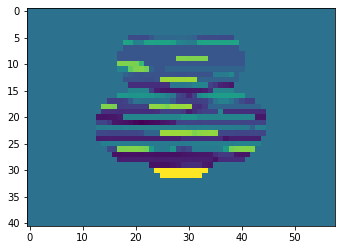

In [25]:

zbt_mask = cormask.flatten()

new_mask = zbt_mask[zbt_mask==1]
new_mask[0:len(ZBTB20_out)]=np.squeeze(ZBTB20_out)

zbt_mask[zbt_mask==1]=new_mask

#[0:len(ZBTB20_out)]=np.squeeze(ZBTB20_out.copy())



plt.imshow(np.resize(zbt_mask, (41,67,58))[:,2,:])
new_mask[1]

Text(0.5, 1.0, 'Output')

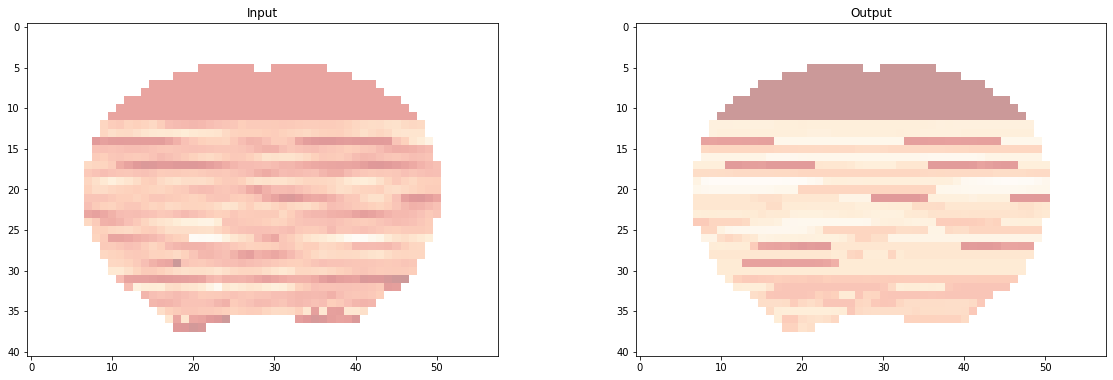

In [26]:
zbt_mask_in = cormask.flatten()

new_mask_in = zbt_mask_in[zbt_mask_in==1]
new_mask_in[0:len(ZBTB20_in)]=np.squeeze(ZBTB20_in)

zbt_mask_in[zbt_mask_in==1]=new_mask_in
zbt_mask_in[zbt_mask_in==0]=np.nan
zbt_mask[zbt_mask==0]=np.nan

#[0:len(ZBTB20_out)]=np.squeeze(ZBTB20_out.copy())
slc = 42
fig, axes = plt.subplots(1, 2, figsize = (2*10, 10/asp))

anat_slice = np.flip(anat[:,slc,:], axis = 0)
atlas_slice = np.flip(atlas[:,slc,:], axis = 0)
kcn_out_slice = np.flip(np.reshape(zbt_mask, (41,67,58))[:,slc,:], axis = 0)
kcn_in_slice = np.flip(np.reshape(zbt_mask_in, (41,67,58))[:,slc,:], axis = 0)

#axes[0].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[0].imshow(kcn_in_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[0].set_title('Input')

#axes[1].imshow(anat_slice, cmap = plt.get_cmap('binary'))
axes[1].imshow(kcn_out_slice, cmap = plt.get_cmap('OrRd'), alpha = 0.4)
axes[1].set_title('Output')


In [27]:
67075/51219

1.3095726195357191